In [1]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Reshape, Input
from tensorflow.keras.models import Model
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [2]:
ANNOTATIONS_PATH = "/kaggle/input/pascal-voc-2012/VOC2012/Annotations/"
IMAGE_PATH = "/kaggle/input/pascal-voc-2012/VOC2012/JPEGImages/"

In [3]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    filename = root.find("filename").text
    objects = []
    for obj in root.findall("object"):
        name = obj.find("name").text
        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        objects.append({"filename": filename, "class": name, 
                        "xmin": xmin, "ymin": ymin, 
                        "xmax": xmax, "ymax": ymax})
    return objects

# Extract data from all XML files
annotations = []
for xml_file in os.listdir(ANNOTATIONS_PATH):
    if xml_file.endswith(".xml"):
        annotations.extend(parse_annotation(os.path.join(ANNOTATIONS_PATH, xml_file)))

# Convert to DataFrame
df = pd.DataFrame(annotations)

# Encode class labels
label_encoder = LabelEncoder()
df["class"] = label_encoder.fit_transform(df["class"])

In [4]:
def load_image(image_filename):
    img_path = os.path.join(IMAGE_PATH, image_filename)
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image) / 255.0
    return image

df["image"] = df["filename"].apply(load_image)

# Convert dataset to tf.data.Dataset

In [7]:
def generator():
    for _, row in df.iterrows():
        yield row["image"], {
            "bbox_output": np.array([[row["xmin"], row["ymin"], row["xmax"], row["ymax"]]], dtype=np.float32),
            "class_output": np.array([row["class"]], dtype=np.int32),
            "rpn_cls_output": np.array([[1]], dtype=np.float32),  # Placeholder for RPN classification
            "rpn_reg_output": np.array([[0, 0, 0, 0]], dtype=np.float32)  # Placeholder for RPN regression
        }

tf_dataset = tf.data.Dataset.from_generator(generator, output_signature=(
    tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
    {
        "bbox_output": tf.TensorSpec(shape=(1, 4), dtype=tf.float32),
        "class_output": tf.TensorSpec(shape=(1,), dtype=tf.int32),
        "rpn_cls_output": tf.TensorSpec(shape=(1, 1), dtype=tf.float32),
        "rpn_reg_output": tf.TensorSpec(shape=(1, 4), dtype=tf.float32),
    }
))

tf_dataset = tf_dataset.batch(8).prefetch(tf.data.experimental.AUTOTUNE)

In [6]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
x = Flatten()(base_model.output)

# Define Region Proposal Network (RPN)
rpn_cls_output = Dense(1, activation="sigmoid", name="rpn_cls_output")(x)
rpn_reg_output = Dense(4, name="rpn_reg_output")(x)

# Define Classification & BBox Regression heads
class_output = Dense(len(label_encoder.classes_), activation="softmax", name="class_output")(x)
bbox_output = Dense(4, name="bbox_output")(x)

# Create Model
model = Model(inputs=base_model.input, outputs=[bbox_output, class_output, rpn_cls_output, rpn_reg_output])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [8]:
model.compile(optimizer="adam", loss={
    "bbox_output": "mse",
    "class_output": "sparse_categorical_crossentropy",
    "rpn_cls_output": "binary_crossentropy",
    "rpn_reg_output": "mse"
})


In [10]:
# Calculate dataset size
dataset_size = len(df)

# Train the model with explicit steps per epoch
model.fit(tf_dataset, epochs=5, steps_per_epoch=dataset_size // 8, verbose=1)


Epoch 1/5
5017/5017 ━━━━━━━━━━━━━━━━━━━━ 509s 101ms/step - bbox_output_loss: 13094.8477 - class_output_loss: 21.1417 - loss: 13146.0615 - rpn_cls_output_loss: 8.0411e-13 - rpn_reg_output_loss: 30.0732
Epoch 2/5
5017/5017 ━━━━━━━━━━━━━━━━━━━━ 25s 12us/step - bbox_output_loss: 28126.6055 - class_output_loss: 4.6138 - loss: 28132.5195 - rpn_cls_output_loss: 2.4383e-11 - rpn_reg_output_loss: 1.3001    
Epoch 3/5
   1/5017 ━━━━━━━━━━━━━━━━━━━━ 14:59 179ms/step - bbox_output_loss: 18691.2734 - class_output_loss: 21.0106 - loss: 18724.9355 - rpn_cls_output_loss: 1.0779e-11 - rpn_reg_output_loss: 12.6516

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


5017/5017 ━━━━━━━━━━━━━━━━━━━━ 510s 102ms/step - bbox_output_loss: 12581.6514 - class_output_loss: 9.6742 - loss: 12596.4111 - rpn_cls_output_loss: 9.1662e-11 - rpn_reg_output_loss: 5.0828
Epoch 4/5
5017/5017 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step - bbox_output_loss: 26298.2344 - class_output_loss: 1.0729e-06 - loss: 26303.5059 - rpn_cls_output_loss: 2.3635e-11 - rpn_reg_output_loss: 5.2715   
Epoch 5/5
5017/5017 ━━━━━━━━━━━━━━━━━━━━ 509s 101ms/step - bbox_output_loss: 12469.4873 - class_output_loss: 6.9889 - loss: 12480.1074 - rpn_cls_output_loss: 2.8802e-11 - rpn_reg_output_loss: 3.6351


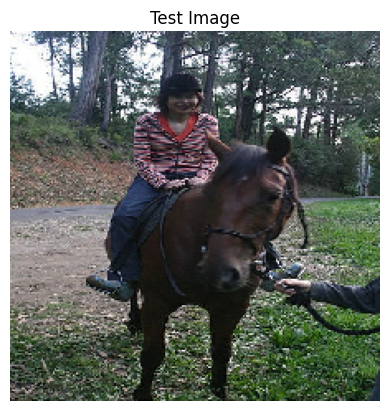

In [11]:
import matplotlib.pyplot as plt

# Select a test image
test_image_filename = df["filename"].iloc[0]  # Pick the first image from dataset
test_image_path = os.path.join(IMAGE_PATH, test_image_filename)

# Load and preprocess the image
test_image = load_img(test_image_path, target_size=(224, 224))
test_image_array = img_to_array(test_image) / 255.0
test_image_array = np.expand_dims(test_image_array, axis=0)  # Add batch dimension

# Display the image
plt.imshow(test_image)
plt.axis("off")
plt.title("Test Image")
plt.show()


In [12]:
# Perform model prediction
predictions = model.predict(test_image_array)

# Extract predictions
predicted_bbox = predictions[0][0]  # Bounding box coordinates (xmin, ymin, xmax, ymax)
predicted_class = np.argmax(predictions[1][0])  # Class label
predicted_class_name = label_encoder.inverse_transform([predicted_class])[0]  # Convert to class name

# Print results
print(f"Predicted Bounding Box: {predicted_bbox}")
print(f"Predicted Class: {predicted_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Bounding Box: [154.42265 113.55517 327.05612 298.0964 ]
Predicted Class: person


In [14]:
import cv2

# Convert bbox coordinates to original image size (assuming 224x224 input)
original_image = cv2.imread(test_image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
h, w, _ = original_image.shape

xmin, ymin, xmax, ymax = predicted_bbox
xmin = int(xmin * w / 224)
ymin = int(ymin * h / 224)
xmax = int(xmax * w / 224)
ymax = int(ymax * h / 224)

# Draw the bounding box
cv2.rectangle(original_image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
cv2.putText(original_image, predicted_class_name, (xmin, ymin - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Display the image with prediction
# plt.imshow(original_image)
# plt.axis("off")
# plt.title("Predicted Bounding Box")
# plt.show()


array([[[120, 129, 146],
        [247, 255, 255],
        [233, 243, 242],
        ...,
        [ 62,  77,  82],
        [ 75,  90,  97],
        [ 53,  67,  76]],

       [[150, 157, 183],
        [167, 174, 192],
        [249, 255, 255],
        ...,
        [ 77,  92,  97],
        [ 81,  96, 103],
        [ 76,  90,  99]],

       [[210, 215, 245],
        [ 88,  92, 119],
        [204, 209, 228],
        ...,
        [ 74,  89,  94],
        [ 69,  84,  91],
        [ 75,  90,  97]],

       ...,

       [[ 53,  53,  51],
        [ 36,  37,  32],
        [ 39,  40,  35],
        ...,
        [ 25,  43,  57],
        [ 25,  43,  57],
        [ 23,  42,  56]],

       [[ 31,  33,  30],
        [ 36,  38,  33],
        [ 54,  56,  51],
        ...,
        [ 25,  43,  57],
        [ 24,  42,  56],
        [ 23,  42,  56]],

       [[ 74,  79,  75],
        [ 66,  71,  65],
        [ 75,  80,  74],
        ...,
        [ 29,  45,  60],
        [ 27,  45,  59],
        [ 27,  45,  59]]